# Top-5 Token Analysis

This notebook analyzes the results from the top-5 token occurrence experiment, visualizing how often options appeared in the top-5 logits and examining the distribution of "other" tokens.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set style
sns.set_theme(style="whitegrid")

In [21]:
# Configuration
EXP_NAME = "qwen05_hist" # Updated to new experiment name
EXP_DIR = os.path.join("experiments", EXP_NAME)

print(f"Analyzing experiment in: {EXP_DIR}")

Analyzing experiment in: experiments/qwen05_hist


In [22]:
# Load Counts
counts_path = os.path.join(EXP_DIR, "top5_counts.csv")
if os.path.exists(counts_path):
    df_counts = pd.read_csv(counts_path, index_col=0)
    print("Loaded counts data.")
    display(df_counts)
else:
    print(f"File not found: {counts_path}")
    df_counts = None

Loaded counts data.


,{A/B},_{A/B},_{color},_{Color},{color},{Color},option,Other
0,0,12,400,6,20,0,12,550
1,0,24,100,19,0,0,4,141
2,0,5,56,32,4,0,4,269
3,0,33,55,50,2,0,0,35
4,0,33,37,54,8,0,0,3


Total Experiments (N): 1000

Cumulative Proportions (Percentage of times appeared in Top-k):


,{A/B},_{A/B},_{color},_{Color},{color},{Color},option,Other
k,,,,,,,,
1,0.0,1.2,40.0,0.6,2.0,0.0,1.2,55.0
2,0.0,3.6,50.0,2.5,2.0,0.0,1.6,69.1
3,0.0,4.1,55.6,5.7,2.4,0.0,2.0,96.0
4,0.0,7.4,61.1,10.7,2.6,0.0,2.0,99.5
5,0.0,10.7,64.8,16.1,3.4,0.0,2.0,99.8


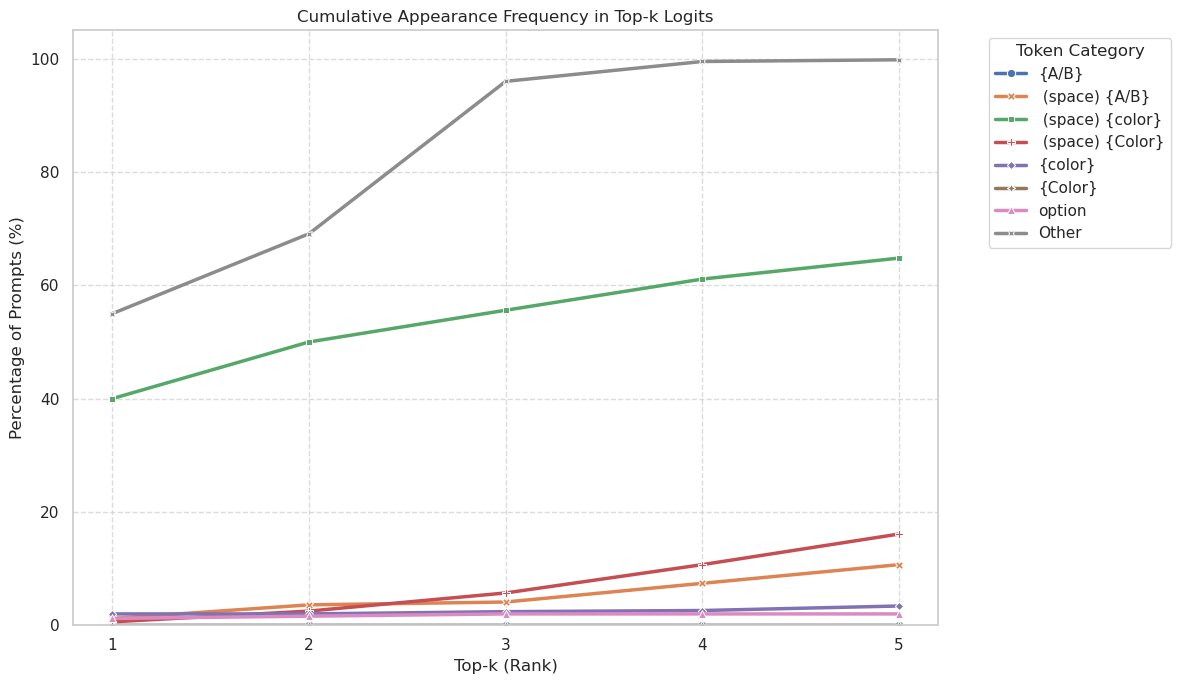

In [23]:
if df_counts is not None:
    # Calculate Total Experiments (N)
    # The sum of counts across all categories for any rank should be numbers of prompts
    total_experiments = df_counts.sum(axis=1).iloc[0]
    print(f"Total Experiments (N): {total_experiments}")

    # Calculate Cumulative Sums for Top-1 to Top-5
    # rows are ranks 0..4, so cumsum over axis 0 aggregates counts for top-1, top-2...
    cumulative_counts = df_counts.cumsum(axis=0)
    
    # Calculate Percentages
    cumulative_props = (cumulative_counts / total_experiments) * 100
    
    # Adjust index to correct k values (1 to 5)
    cumulative_props.index = range(1, 6) # k=1 to 5
    cumulative_props.index.name = "k"
    
    print("\nCumulative Proportions (Percentage of times appeared in Top-k):")
    display(cumulative_props)
    
    # Plot Lines
    plt.figure(figsize=(12, 7))
    
    # Define cleaner labels for legend
    clean_labels = {col: col.replace("_", " (space) ") for col in cumulative_props.columns}
    cumulative_props_renamed = cumulative_props.rename(columns=clean_labels)
    
    sns.lineplot(data=cumulative_props_renamed, markers=True, dashes=False, linewidth=2.5)
    
    plt.title("Cumulative Appearance Frequency in Top-k Logits")
    plt.ylabel("Percentage of Prompts (%)")
    plt.xlabel("Top-k (Rank)")
    plt.xticks(range(1, 6))
    plt.ylim(0, 105) # Keep 0-100 scale context
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Token Category")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [24]:
# Load Others
others_path = os.path.join(EXP_DIR, "top5_others.csv")
if os.path.exists(others_path):
    df_others = pd.read_csv(others_path, names=["Token", "Count"], header=None, skiprows=1) # Assuming header in csv or just series save format
    # Check if the first row is actually the header or data based on saved format
    # pd.Series.to_csv saves index (token) and value (count). 1st line might be header if header=True (default)
    # The previous code used df_others.to_csv which includes header by default.
    df_others = pd.read_csv(others_path, index_col=0)
    df_others.columns = ["Count"] # Ensure column name
    
    print("Loaded others data.")
    print(f"Total unique 'other' tokens: {len(df_others)}")
    display(df_others.head(10))
else:
    print(f"File not found: {others_path}")
    df_others = None

Loaded others data.
Total unique 'other' tokens: 129


,Count
,565
red,195
blue,188
green,159
(,134
[,111
true,107
The,90
"""",90
a,87


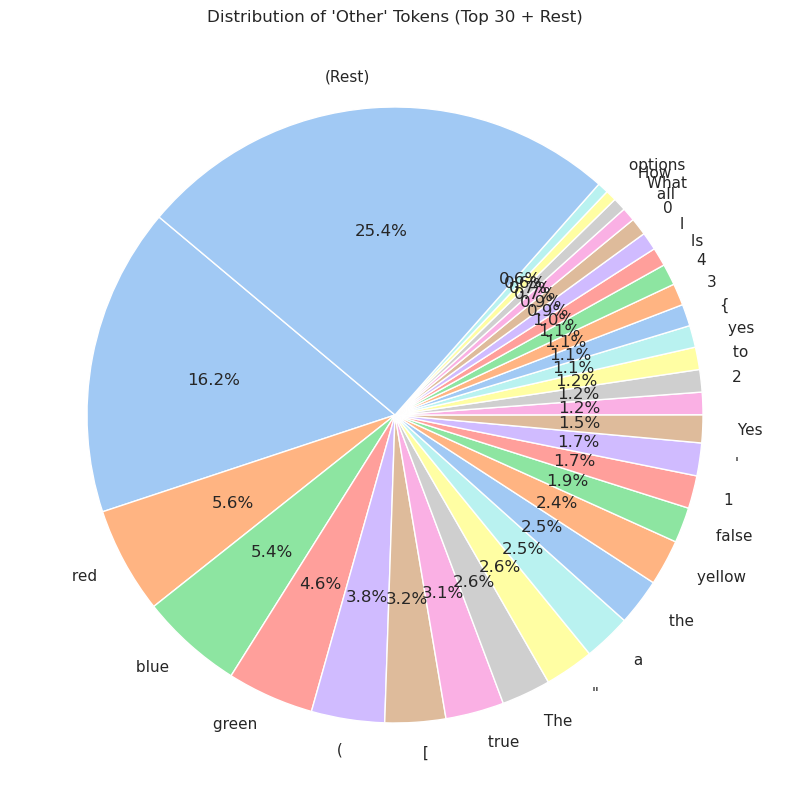

In [25]:
if df_others is not None:
    # Filter for significant "others"
    # Group small counts into "Rest" for cleaner pie chart
    top_n = 30
    df_others_sorted = df_others.sort_values("Count", ascending=False)
    
    top_others = df_others_sorted.head(top_n)
    rest_count = df_others_sorted.iloc[top_n:]['Count'].sum()
    
    # Create data for pie chart
    pie_data = top_others['Count'].copy()
    if rest_count > 0:
        pie_data["(Rest)"] = rest_count
        
    plt.figure(figsize=(10, 10))
    plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
    plt.title(f"Distribution of 'Other' Tokens (Top {top_n} + Rest)")
    plt.show()